In [3]:
from backtesting import Backtest, Strategy
import yfinance as yf
import json
import pandas as pd
import datetime
import pandas_ta as ta
import tqdm
filemap = {
    "NYSE"  : "../Database/zackRanks_NYSE.json", # 1352
    "NASDAQ": '../Database/zackRanks_NASDAQ.json', # small:1255; mid:330; large:72
    "SP500" : "../Database/zackRanks_SP500.json", # small: 1352
   "Yuanta": "../Database/zackRanks_yuanta.json"
}
def get_tickers(file="SP500"):
    dict = pd.read_csv(filemap[file], header=None)
    dict = dict.iloc[:, 0]
    return dict

def WPRbt(data):
    period = 12
    max = data.Close.rolling(period).max()
    min = data.Close.rolling(period).min()
    wpr = (max - data.Close)/(max - min) * (-100) 
    return wpr

def check_WPR_2MA_without_DB(ticker, test=False, period_long_ma=28, period_short_ma=14, upb=-20, lob=-80):
    a = yf.download(ticker, start=datetime.datetime.now() - datetime.timedelta(days=50), interval="1d", progress=False)

    # a["WPR"] = WPRbt(a)
    a["MAX"] = a.High.rolling(12).max()
    a["MIN"] = a.Low.rolling(12).min()
    a["WPRs"] = (a.MAX - a.Close)/(a.MAX - a.MIN) * (-100)
    a["long_MA"] = a.Close.ewm(span=period_long_ma, adjust=False, min_periods=period_long_ma).mean()
    a['short_MA'] = a.Close.ewm(span=period_short_ma, adjust=False, min_periods=period_short_ma).mean()
    long0 = a['long_MA'][-1]
    long1 = a['long_MA'][-2]
    long2 = a['long_MA'][-3]
    long3 = a['long_MA'][-4]
    # =======================
    short0 = a['short_MA'][-1]
    short1 = a['short_MA'][-2]
    short2 = a['short_MA'][-3]
    short3 = a['short_MA'][-4]
    # =======================
    wpr0 = a['WPRs'][-1]
    wpr1 = a['WPRs'][-2]
    wpr2 = a['WPRs'][-3]
    wpr3 = a['WPRs'][-4]
    check_ma_percent = 0.0000# for PAYX at 2024-02-08, 0.005 return 4(meaning doesn't work ) while 0.006 works
    bear_market = (long0 - short0 > long0*check_ma_percent) and (long1 - short1 > long1*check_ma_percent) and (long2 - short2 > long2*check_ma_percent)
    bull_market = (long0 - short0 < long0*-check_ma_percent) and (long1 - short1 < long1*-check_ma_percent) and (long2 - short2 < long2*-check_ma_percent)
    if test:
        print(a[['Close', "short_MA", "long_MA", "WPRs", "MAX"]])
        print(wpr0, wpr1, wpr2, wpr3)
        print("quick: ", [short3, short2, short1, short0])
        print("slow: ", [long3, long2, long1, long0])
    # current signal
    if((wpr0 < upb) and (wpr1 > upb) and bear_market):
        # print(ticker, "cross above"):
            # sell signal
        return 1
    elif ((wpr0 > lob) and (wpr1 < lob)) and bull_market:
        # buy signal
        return 2
    # check for yesterday or the day before yesterday buy/sell signal
    elif((wpr1 < upb) and (wpr2 > upb) and bear_market):
        return 1.5
    elif((wpr1 > lob) and (wpr2 < lob) and bull_market):
        return 2.5
    elif((wpr2 > lob) and (wpr3 < lob) and bull_market) or ((wpr2 > upb) and (wpr3 < upb) and bear_market):
        return 3

    else:
        return 0
k = "SP500"
if __name__ == "__main__":
    # TradingView Missed; Python Passed => Correct Signal: VLTO
    # print(check_WPR_2MA_without_DB("VSTS", test=True))
    if k not in ["zack1", "zack2"]:
        # print(a)
        with open(filemap[k], 'r') as f:
        ## 轉成Python Dict
            python_dict = json.load(f)
        a = list(python_dict.keys())
        if k == "SP500" or k == "Yuanta":
            tickers = a[:]
        elif k == "NYSE":
            tickers = a[1:1352]
        elif k == "NASDAQ":
            tickers = a[1:1255]
    elif k == "zack2":
        tickers = [
  'MSFT', 'NVDA', 'JPM',  'MA',   'COST', 'IBM',  'QCOM', 'UBER',
  'ELV',  'AXP',  'SYK',  'LRCX', 'BLK',  'MDLZ', 'CB',   'ETN',
  'MU',   'BSX',  'CI',   'CDNS', 'EQIX', 'CME',  'DUK',  'ICE',
  'BDX',  'CL',   'MCK',  'ANET', 'TGT',  'NOC',  'PH',   'GM',
  'CTAS', 'EMR',  'LULU', 'TRV',  'EW',   'DXCM', 'AFL',  'TEL',
  'ALL',  'CNC',  'GWW',  'PAYX', 'FAST', 'CEG',  'COR',  'AME',
  'RSG',  'XEL',  'KMI',  'VICI', 'FICO', 'FTV',  'CAH',  'ZBH',
  'HIG',  'HPQ',  'CHD',  'AWK',  'WAB',  'STT',  'HWM',  'DTE',
  'DRI',  'CBOE', 'VTR',  'WDC',  'STLD', 'BRO',  'HOLX', 'CINF',
  'PFG',  'VLTO', 'WRB',  'CCL',  'STX',  'NTRS', 'SYF',  'JBL',
  'MAS',  'LDOS', 'LW',   'CE',   'NDSN', 'GEN',  'LNT',  'JKHY',
  'TAP',  'FFIV', 'GL',   'NI',   'QRVO', 'UHS',  'AAL',  'TPR',
  'AIZ',  'BEN',  'FRT',  'DVA'
]
    elif k == "zack1":
        tickers = [
  'AMZN', 'META', 'NFLX',
  'PGR',  'ABNB', 'HCA',
  'PCAR', 'BK',   'OKE',
  'RCL',  'TROW', 'NVR',
  'CLX',  'TXT',  'TSN',
  'HII',  'RL',   'GPS'
]

    # Using tqdm to add a progress bar
    with tqdm.tqdm(total=len(tickers)) as pbar:
        res = {}
        for ticker in tickers:
            res[ticker] = check_WPR_2MA_without_DB(ticker)
            pbar.update(1)  # Update the progress bar
    print(res)
    s = [{i:res[i]} for i in res.keys() if res[i] != 0 ]
    if sum(list(res.values())) == 0:
        print("there's nothing with signal")
    print(s)
# import js2py

import subprocess
import json
# one check
# q = [i for i in res.keys() if res[i] == 1]
checks = [1, 2]
for check in checks:
    q = [i for i in res.keys() if res[i] == check]
    q
    dict_res = {}
    print(len(q))
    for ticker in q:
        command = "zacks-api " + ticker
        result = subprocess.check_output(command, shell=True)
        dict = eval(result.decode(("utf-8"))) 
        
        dict_res[ticker] = dict['zacksRank']
    if check == 1:
        # print("sell")
        sell = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "4"]
        strong_sell = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "5"]
        print("Strong Sell:", strong_sell)
        print("Sell: ", sell)
        res_sell = strong_sell #+ sell
    if check == 2:
        # print("buy")
        strong_buy = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "1"]
        buy = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "2"]
        print("Strong Buy:", strong_buy)
        print("Buy: ", buy)
        res_buy = strong_buy #+ buy
    print(json.dumps(dict_res, indent=4))
    print("=============")

print(res_buy)
print(res_sell)

# print(ticker for ticker in dict_res.keys() if dict_res[ticker] == 5)
# questionable: 3 Flex, 2024-2-12

  0%|          | 0/499 [00:00<?, ?it/s]

100%|██████████| 499/499 [01:15<00:00,  6.58it/s]


{'MSFT': 0, 'AAPL': 0, 'NVDA': 0, 'AMZN': 0, 'META': 0, 'GOOGL': 0, 'GOOG': 0, 'AVGO': 0, 'TSLA': 0, 'LLY': 0, 'JPM': 0, 'UNH': 0, 'V': 0, 'XOM': 2, 'JNJ': 0, 'MA': 0, 'PG': 2, 'HD': 0, 'COST': 0, 'MRK': 0, 'ABBV': 0, 'ADBE': 0, 'CRM': 0, 'AMD': 0, 'CVX': 0, 'NFLX': 2.5, 'WMT': 0, 'BAC': 0, 'PEP': 0, 'KO': 0, 'ACN': 2.5, 'MCD': 0, 'TMO': 2.5, 'CSCO': 0, 'ABT': 2.5, 'LIN': 0, 'CMCSA': 0, 'INTC': 0, 'WFC': 0, 'VZ': 0, 'ORCL': 0, 'INTU': 0, 'DIS': 0, 'AMGN': 0, 'IBM': 0, 'QCOM': 0, 'DHR': 0, 'NOW': 0, 'CAT': 0, 'PFE': 0, 'UNP': 0, 'TXN': 0, 'SPGI': 0, 'GE': 0, 'PM': 0, 'AMAT': 0, 'UBER': 0, 'HON': 0, 'ISRG': 0, 'COP': 0, 'RTX': 0, 'T': 0, 'GS': 0, 'NKE': 0, 'LOW': 0, 'BKNG': 0, 'NEE': 0, 'BA': 0, 'PLD': 0, 'MDT': 0, 'ELV': 0, 'AXP': 0, 'SYK': 0, 'VRTX': 0, 'MS': 0, 'LRCX': 0, 'TJX': 0, 'BLK': 0, 'C': 2, 'SBUX': 0, 'DE': 0, 'PANW': 0, 'PGR': 0, 'UPS': 0, 'MDLZ': 0, 'ADP': 0, 'REGN': 0, 'CB': 0, 'BMY': 0, 'ETN': 0, 'GILD': 0, 'ADI': 0, 'MMC': 0, 'CVS': 0, 'LMT': 0, 'MU': 0, 'SCHW': 0, 'BSX'

2024-02-14 add function: comparison of strategy filter and zacks rank

Simply using command line operation to compare ranks (js2py => next version)

Write into JSON file

In [4]:
import json
## 讀取JSON檔
# k = "SP500"
with open('../Database/buy.json', 'r') as f:
  ## 轉成Python Dict
  python_dict = json.load(f)

# q = [i for i in res.keys() if res[i] == 2 ]
time = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
python_dict[k][time] = res_buy

# 讀取JSON檔
with open('../Database/buy.json', 'w') as f:
  ## 將內容裝進text
  json.dump(python_dict, f, indent=4)

import json
## 讀取JSON檔
with open('../Database/sell.json', 'r') as f:
  ## 轉成Python Dict
  python_dict_sell = json.load(f)
# r = [i for i in res_sell.keys() if res[i] == 1 ]
python_dict_sell[k][time] = res_sell
## 讀取JSON檔
with open('../Database/sell.json', 'w') as f:
  ## 將內容裝進text
  json.dump(python_dict_sell, f, indent=4)

print(python_dict[k][time])
print(python_dict_sell[k][time])
print(time)

[]
[]
2024-02-15


Plot SP500 based on Sectors in order to choose the right direction of WPR_2MA, so that the high possibility loss could be filtered 

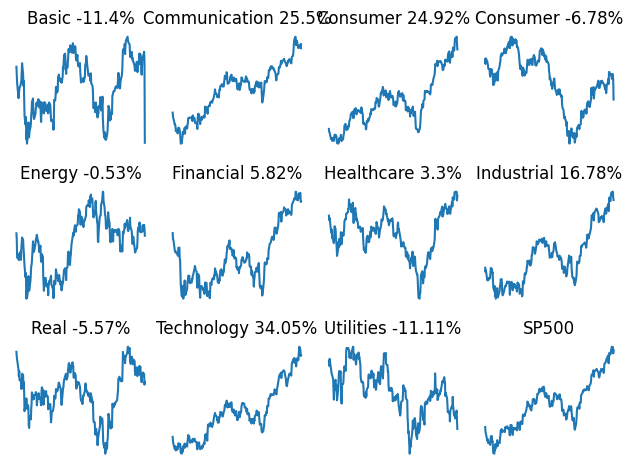

{'Basic': [-13.27, -5.46, -3.06, -11.4],
 'Communication': [7.75, 15.97, 22.79, 25.5],
 'Consumer': [-1.99, 6.08, -4.84, -6.78],
 'Energy': [-3.84, -0.77, 11.53, -0.53],
 'Financial': [2.57, 13.03, 16.53, 5.82],
 'Healthcare': [3.46, 10.26, 9.42, 3.3],
 'Industrial': [5.46, 16.94, 22.37, 16.78],
 'Real': [-3.83, 9.66, 5.23, -5.57],
 'Technology': [12.14, 25.45, 28.66, 34.05],
 'Utilities': [-7.91, 1.85, -5.15, -11.11]}

In [14]:
# 30 secs
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf 
import json
import datetime
with open("../Database/us_stock.json", "r") as f:
  python_dict = json.load(f)
dict_return_comparison = {}
mat = list(python_dict["SP500"].keys())
fig, ax = plt.subplots(3, 4)
start = datetime.datetime.now() - datetime.timedelta(days=365)
for i, bas in enumerate(mat):
  
  a = yf.download(python_dict["SP500"][bas], start=start, progress=False)
  close = a["Close"]
  avg = close.sum(axis=1)/len(close.columns)
  percentage_change_year = round(((avg[-1]-avg[0])/avg[0])*100, 2)
  percentage_change_month = round(((avg[-1]-avg[-30])/avg[0])*100, 2)
  percentage_change_3m = round(((avg[-1]-avg[-90])/avg[0])*100, 2)
  percentage_change_6m = round(((avg[-1]-avg[-180])/avg[0])*100, 2)
  class_name = bas.split(" ")[0]
  dict_return_comparison[class_name] = [percentage_change_month, percentage_change_3m, percentage_change_6m, percentage_change_year]
  title = class_name + " " + str(percentage_change_year) + "%"
  if 0 <= i <= 3:
    ax[0, i].plot(avg)
    ax[0, i].set_title(title)
    ax[0, i].axis("off")
  if 4 <= i <= 7:
    ax[1, i-4].plot(avg)
    ax[1, i-4].set_title(title)
    ax[1, i-4].axis("off")
  if 8 <= i <= 10:
    ax[2, i-8].plot(avg)
    ax[2, i-8].set_title(title) 
    ax[2, i-8].axis("off")
k = yf.download("^GSPC",start=start, progress=False)
ax[2, 3].plot(k['Close'])
ax[2, 3].set_title("SP500")
ax[2, 3].axis("off")
plt.tight_layout()
plt.show()

dict_return_comparison

In [35]:
# print(dict_return_comparison.items())
interval = 2
comp = {
    0: "monthly",
    1: "3 months",
    2: "6  months",
    3: "yearly"
}
def geykey(item):
    return item[1]
sorted_dict = sorted(dict_return_comparison.items(), key=lambda x:x[1][interval], reverse=True)
returns = {}
for i, value in enumerate(sorted_dict):
    returns[value[0]] = dict_return_comparison[value[0]]
print(comp[interval])
returns

6  months


{'Technology': [12.14, 25.45, 28.66, 34.05],
 'Communication': [7.75, 15.97, 22.79, 25.5],
 'Industrial': [5.46, 16.94, 22.37, 16.78],
 'Financial': [2.57, 13.03, 16.53, 5.82],
 'Energy': [-3.84, -0.77, 11.53, -0.53],
 'Healthcare': [3.46, 10.26, 9.42, 3.3],
 'Real': [-3.83, 9.66, 5.23, -5.57],
 'Basic': [-13.27, -5.46, -3.06, -11.4],
 'Consumer': [-1.99, 6.08, -4.84, -6.78],
 'Utilities': [-7.91, 1.85, -5.15, -11.11]}

In [23]:
list(dict_return_comparison.values())


[[-13.27, -5.46, -3.06, -11.4],
 [7.75, 15.97, 22.79, 25.5],
 [-1.99, 6.08, -4.84, -6.78],
 [-3.84, -0.77, 11.53, -0.53],
 [2.57, 13.03, 16.53, 5.82],
 [3.46, 10.26, 9.42, 3.3],
 [5.46, 16.94, 22.37, 16.78],
 [-3.83, 9.66, 5.23, -5.57],
 [12.14, 25.45, 28.66, 34.05],
 [-7.91, 1.85, -5.15, -11.11]]